In [38]:
import os
import torch
from torchvision.datasets import CIFAR100, CIFAR10
from transformers import DistilBertTokenizer
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

import sys
sys.path.append('../')
from factory import MAECLIPFactory
from misc.transforms import get_original_vit_image_encoder_transforms

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [13]:
class CFG:

    text_encoder_name = "distilbert-base-uncased"
    text_encoder_pretrained = True
    text_encoder_trainable = False
    
    temperature = 1.0
    image_size = 224
    patch_size = 14
    image_embedding = 512
    text_embedding = 768
    projection_dim = 256
    dropout = 0.1

    mask_ratio = 0.75
    alpha = 0

device = 'cuda'

In [1]:
model_path = "/home/ykojima/Desktop/clip/mae_clip/20240118_mae_clip_joint_scratch_training_alpha=0/checkpoint_8.pth"

In [10]:
cfg = CFG()
factory = MAECLIPFactory(cfg)
model = factory.create().to("cuda")
model.load_state_dict(torch.load(model_path, map_location="cuda"))
model = model.clip
model.eval()

CLIP(
  (_image_encoder): MAE_Encoder(
    (patchify): Conv2d(3, 512, kernel_size=(14, 14), stride=(14, 14))
    (transformer): Sequential(
      (0): Block(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=512, out_features=1536, bias=False)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=512, out_features=512, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (act): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (

In [11]:
# Download the dataset
cifar100 = CIFAR10(root=os.path.expanduser("~/.cache"), download=True, train=False)

100%|████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:27<00:00, 6222319.57it/s]


Extracting /home/ykojima/.cache/cifar-10-python.tar.gz to /home/ykojima/.cache


In [14]:
text_inputs = tokenizer([f"a photo of a {c}" for c in cifar100.classes], padding=True, return_tensors='pt').to(device)

(32, 32)
cat
torch.Size([1, 3, 224, 224])


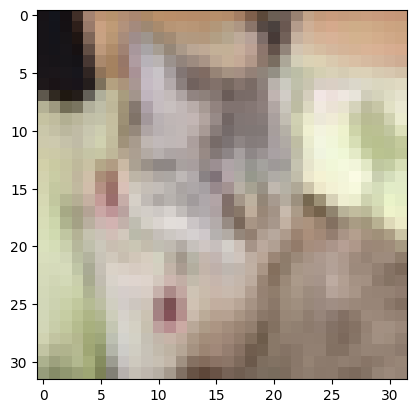

In [32]:
transforms = get_original_vit_image_encoder_transforms('valid')

# Prepare the inputs
image, class_id = cifar100[8]
plt.imshow(image)
print(image.size)
print(cifar100.classes[class_id])
image = transforms(image).unsqueeze(0).to(device)
print(image.shape)

In [33]:
# Calculate features
with torch.no_grad():
    image_features = model.image_encode(image)
    text_features = model.text_encode(input_ids=text_inputs["input_ids"], attention_mask=text_inputs["attention_mask"])

not masked


In [34]:
image_features.shape
text_features.shape

torch.Size([10, 256])

In [40]:
# Pick the top 5 most similar labels for the image
image_features_n = F.normalize(image_features, dim=-1)
text_features_n = F.normalize(text_features, dim=-1) # shape: (n, 256)

similarity = (image_features_n @ text_features_n.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

In [41]:
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

            frog: 10.28%
             cat: 10.21%
             dog: 10.20%
            deer: 10.16%
            bird: 10.15%
